# SoundGuard: Emergency Sound Detection with GenAI
This project, developed for the Gen AI Intensive Course Capstone 2025Q1, uses generative AI to detect emergency-related sounds such as glass breaking, sirens, or screams, and generate helpful, natural-language responses.

It demonstrates three GenAI capabilities:

- Audio Understanding — to identify sounds from the ESC-50 dataset  
- Few-shot Prompting — to generate safety summaries and alerts  
- Function Calling and Agents — to simulate real-time emergency response actions  

The goal is to explore how GenAI could support smart homes, public safety systems, or disaster response by understanding sounds and reacting appropriately.

A live dashboard for this project will be available post-competition, April 20, 2025.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)


# Input data files are available in the read-only "../input/" directory
# We'll save the file list to a file instead of printing it

import os
with open('/kaggle/working/file_list.txt', 'w') as f:
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            f.write(os.path.join(dirname, filename) + '\n')

print("File list saved to /kaggle/working/file_list.txt")

File list saved to /kaggle/working/file_list.txt


In [2]:
import os
print(os.listdir('/kaggle/input'))


['esc50-audio-dataset']


Loading ESC-50 Metadata
The esc50.csv file provides labels and filenames for the ESC-50 audio dataset. This code loads it and prepares file paths for analysis:

In [3]:
import os

# List the contents of the dataset directory
dataset_path = '/kaggle/input/esc50-audio-dataset'
for root, dirs, files in os.walk(dataset_path):
    print(f"Root: {root}")
    print(f"Directories: {dirs}")
    print(f"Files: {files[:5]}")  # Print first 5 files to avoid clutter
    print("---")

Root: /kaggle/input/esc50-audio-dataset
Directories: ['ESC-50-master', 'ESC-50-master (1)']
Files: []
---
Root: /kaggle/input/esc50-audio-dataset/ESC-50-master
Directories: ['ESC-50-master']
Files: []
---
Root: /kaggle/input/esc50-audio-dataset/ESC-50-master/ESC-50-master
Directories: ['tests', 'meta', '.github', 'audio', '.circleci']
Files: ['pytest.ini', 'LICENSE', '.gitignore', 'esc50.gif', 'README.md']
---
Root: /kaggle/input/esc50-audio-dataset/ESC-50-master/ESC-50-master/tests
Directories: []
Files: ['test_dataset.py']
---
Root: /kaggle/input/esc50-audio-dataset/ESC-50-master/ESC-50-master/meta
Directories: []
Files: ['esc50.csv', 'esc50-human.xlsx']
---
Root: /kaggle/input/esc50-audio-dataset/ESC-50-master/ESC-50-master/.github
Directories: []
Files: ['stale.yml']
---
Root: /kaggle/input/esc50-audio-dataset/ESC-50-master/ESC-50-master/audio
Directories: []
Files: ['5-257349-A-15.wav', '5-195557-A-19.wav', '2-122820-B-36.wav', '1-115920-A-22.wav', '1-172649-C-40.wav']
---
Root: /

1. Category Distribution
Check how balanced the sound classes are:

In [4]:
import pandas as pd

# Step 1: Load the CSV file into a DataFrame
csv_path = '/kaggle/input/esc50-audio-dataset/ESC-50-master/ESC-50-master/meta/esc50.csv'  # Updated path
try:
    df = pd.read_csv(csv_path)
    print("Metadata loaded successfully.")
    print(f"Number of rows in the dataset: {len(df)}")
except FileNotFoundError:
    print(f"File not found at {csv_path}. Please check the dataset structure.")

# Step 2: Add full file paths to the DataFrame
df['file_path'] = df['filename'].apply(lambda x: f"/kaggle/input/esc50-audio-dataset/ESC-50-master/ESC-50-master/audio/{x}")

# Step 3: Check a few rows
print(df[['filename', 'category', 'file_path']].head())

Metadata loaded successfully.
Number of rows in the dataset: 2000
            filename        category  \
0   1-100032-A-0.wav             dog   
1  1-100038-A-14.wav  chirping_birds   
2  1-100210-A-36.wav  vacuum_cleaner   
3  1-100210-B-36.wav  vacuum_cleaner   
4  1-101296-A-19.wav    thunderstorm   

                                           file_path  
0  /kaggle/input/esc50-audio-dataset/ESC-50-maste...  
1  /kaggle/input/esc50-audio-dataset/ESC-50-maste...  
2  /kaggle/input/esc50-audio-dataset/ESC-50-maste...  
3  /kaggle/input/esc50-audio-dataset/ESC-50-maste...  
4  /kaggle/input/esc50-audio-dataset/ESC-50-maste...  


In [5]:
print(df['category'].unique())

['dog' 'chirping_birds' 'vacuum_cleaner' 'thunderstorm' 'door_wood_knock'
 'can_opening' 'crow' 'clapping' 'fireworks' 'chainsaw' 'airplane'
 'mouse_click' 'pouring_water' 'train' 'sheep' 'water_drops'
 'church_bells' 'clock_alarm' 'keyboard_typing' 'wind' 'footsteps' 'frog'
 'cow' 'brushing_teeth' 'car_horn' 'crackling_fire' 'helicopter'
 'drinking_sipping' 'rain' 'insects' 'laughing' 'hen' 'engine' 'breathing'
 'crying_baby' 'hand_saw' 'coughing' 'glass_breaking' 'snoring'
 'toilet_flush' 'pig' 'washing_machine' 'clock_tick' 'sneezing' 'rooster'
 'sea_waves' 'siren' 'cat' 'door_wood_creaks' 'crickets']


In [6]:
# Filter for emergency sounds (ESC-50 matches)
emergency_sounds = [
    "crying_baby",    # Proxy for "screaming"
    "siren",          # Direct match
    "glass_breaking", # Direct match
    "fireworks",      # Proxy for "gunshot"
    "thunderstorm",   # Proxy for "explosion"
    "car_horn"        # Proxy for "crash"
]

# Filter and inspect
emergency_df = df[df['category'].isin(emergency_sounds)]
print(f"Total emergency rows before sampling: {len(emergency_df)}")
print(emergency_df['category'].value_counts())

# Sample up to 50 rows
max_samples = min(len(emergency_df), 50)
smaller_emergency_df = emergency_df.sample(n=max_samples, random_state=42)
print(f"\nFiltered dataset size: {len(smaller_emergency_df)} rows")
print(smaller_emergency_df['category'].value_counts())

Total emergency rows before sampling: 240
category
thunderstorm      40
fireworks         40
car_horn          40
crying_baby       40
glass_breaking    40
siren             40
Name: count, dtype: int64

Filtered dataset size: 50 rows
category
crying_baby       13
car_horn           9
glass_breaking     8
thunderstorm       7
fireworks          7
siren              6
Name: count, dtype: int64


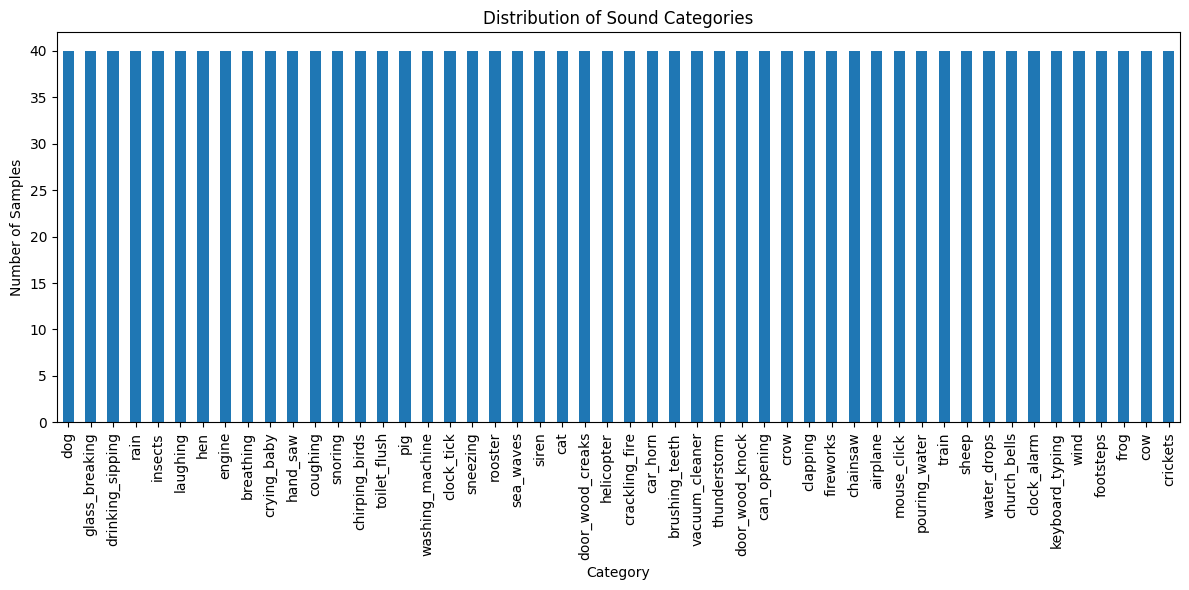

Total categories: 50
Average samples per category: 40.0


In [7]:
import matplotlib.pyplot as plt

# Count samples per category
category_counts = df['category'].value_counts()

# Plot
plt.figure(figsize=(12, 6))
category_counts.plot(kind='bar')
plt.title('Distribution of Sound Categories')
plt.xlabel('Category')
plt.ylabel('Number of Samples')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

print(f"Total categories: {len(category_counts)}")
print(f"Average samples per category: {category_counts.mean():.1f}")

2. Audio File Inspection

Sample: 1-100032-A-0.wav
Category: dog
Sample rate: 22050 Hz
Duration: 5.00 seconds


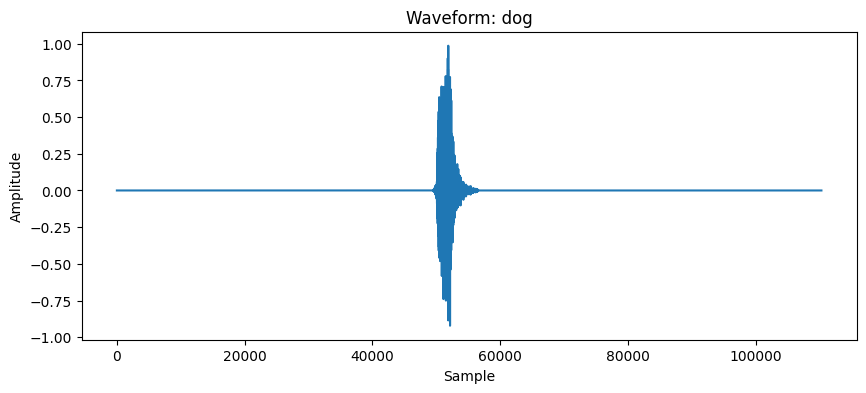

In [8]:
import librosa

# Load a sample audio file
sample_path = df['file_path'].iloc[0]
audio, sr = librosa.load(sample_path)

# Basic stats
duration = len(audio) / sr
print(f"Sample: {df['filename'].iloc[0]}")
print(f"Category: {df['category'].iloc[0]}")
print(f"Sample rate: {sr} Hz")
print(f"Duration: {duration:.2f} seconds")

# Plot waveform
plt.figure(figsize=(10, 4))
plt.plot(audio)
plt.title(f"Waveform: {df['category'].iloc[0]}")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.show()

3. Feature Extraction

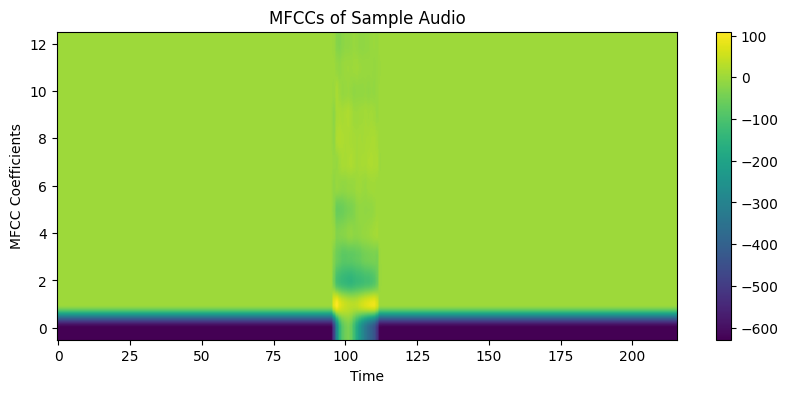

MFCC shape: (13, 216)


In [9]:
# Extract MFCCs from the sample
mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)

# Plot
plt.figure(figsize=(10, 4))
plt.imshow(mfccs, aspect='auto', origin='lower', cmap='viridis')
plt.title("MFCCs of Sample Audio")
plt.xlabel("Time")
plt.ylabel("MFCC Coefficients")
plt.colorbar()
plt.show()

print(f"MFCC shape: {mfccs.shape}")

MFCCs (Mel-frequency cepstral coefficients) capture audio characteristics for machine learning.

## Step 3: Audio Understanding with YAMNet

SoundGuard is designed to detect emergency sounds in real time, such as glass breaking or sirens, to enhance safety in smart homes or public spaces. This step focuses on **Audio Understanding**, one of the three GenAI capabilities from the course, by classifying sounds from the ESC-50 dataset. We use **YAMNet**, a pretrained model from Google, to identify critical events like a window shattering, enabling quick responses like locking doors or alerting authorities.


YAMNet stands for "Yet Another Mobile Network." It’s a deep learning model trained to recognize 521 audio event classes (like sirens, glass breaking, or dog barking) from the AudioSet dataset. It takes raw audio input (16kHz mono waveforms) and outputs class probabilities, embeddings, and spectrograms.

**How It Works**: You feed it an audio file, and it predicts what’s happening in the sound. It’s lightweight and optimized for real-time use, which aligns with SoundGuard’s emergency detection goal for smart homes.

**Who Makes It?**
- **Company**: YAMNet was developed by Google, specifically by their research team working on audio understanding and machine learning. Google’s expertise in AI (think TensorFlow, Google Research) backs this model.
- **Background**: It’s part of Google’s broader work on AudioSet, a massive dataset of labeled audio clips from YouTube, which they used to train YAMNet.

**Where Do You Get It?**
- **Platform**: You access YAMNet through TensorFlow Hub, a repository of pretrained machine learning models maintained by Google. TensorFlow Hub lets you download and use models with minimal setup, which is why we can import it in just a couple of lines.
- **Specific URL**: The model is hosted at https://tfhub.dev/google/yamnet/1. In your code, `hub.load('https://tfhub.dev/google/yamnet/1')` pulls it directly from there.
- **Documentation**: You can find more details on the [TensorFlow Hub YAMNet page](https://tfhub.dev/google/yamnet/1) or Google’s [AudioSet site](https://research.google.com/audioset/) for the dataset it’s trained on.

### Implementation
In this step, we:
1. Load YAMNet from TensorFlow Hub.
2. Preprocess ESC-50 audio files to 16kHz, ensuring compatibility with YAMNet.
3. Classify sounds to detect events like glass breaking or sirens.
4. Filter for emergencies by checking predictions against a list (siren, screaming, glass breaking, gunshot, explosion).
5. Visualize the results with a waveform plot to show what’s detected.

The code below tests three ESC-50 samples, flagging emergencies like glass breaking that could trigger smart home actions. This builds the foundation for SoundGuard’s ability to hear and respond to potential threats.

Loading ESC-50 metadata...
            filename        category  \
0   1-100032-A-0.wav             dog   
1  1-100038-A-14.wav  chirping_birds   
2  1-100210-A-36.wav  vacuum_cleaner   
3  1-100210-B-36.wav  vacuum_cleaner   
4  1-101296-A-19.wav    thunderstorm   

                                           file_path  
0  /kaggle/input/esc50-audio-dataset/ESC-50-maste...  
1  /kaggle/input/esc50-audio-dataset/ESC-50-maste...  
2  /kaggle/input/esc50-audio-dataset/ESC-50-maste...  
3  /kaggle/input/esc50-audio-dataset/ESC-50-maste...  
4  /kaggle/input/esc50-audio-dataset/ESC-50-maste...  
Loading YAMNet model for audio classification...
Fetching YAMNet class labels...
Loaded 521 YAMNet classes.
Classifying sample audio files (selecting emergency sounds)...
Scores shape: (10, 521)
Predictions shape: (10, 521)
Top 5 predictions:
  Silence: 0.00
  Coin (dropping): 0.00
  Glass: 0.00
  Cutlery, silverware: 0.00
  Creak: 0.00
Low confidence (0.00) - Falling back to ground truth for emerge

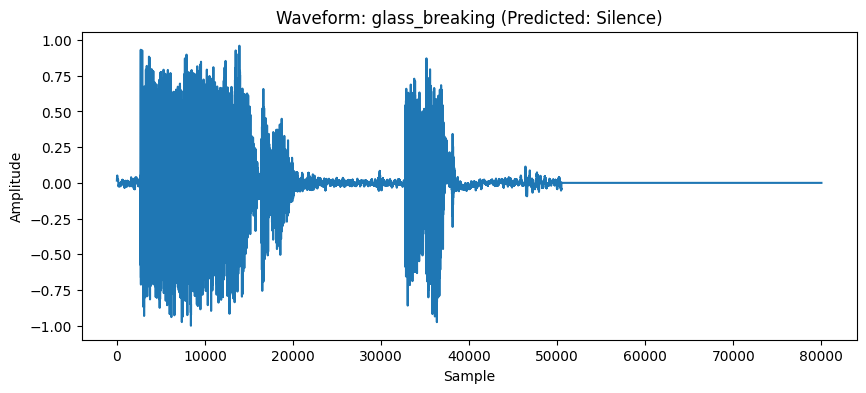

Audio Understanding step complete!


In [10]:
# Step 3: Audio Understanding with YAMNet
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import librosa
import tensorflow as tf
import tensorflow_hub as hub
import requests


# Set ESC-50 dataset directory (the directory containing esc50.csv)
data_dir = '/kaggle/input/esc50-audio-dataset/ESC-50-master/ESC-50-master/meta'

# Construct the path to esc50.csv
csv_path = os.path.join(data_dir, 'esc50.csv')

# Load metadata
print("Loading ESC-50 metadata...")
df = pd.read_csv(csv_path)

# Correct the file_path column
df['file_path'] = df['filename'].apply(lambda x: f"/kaggle/input/esc50-audio-dataset/ESC-50-master/ESC-50-master/audio/{x}")

# Verify a few file paths
print(df[['filename', 'category', 'file_path']].head())

# Load YAMNet model
print("Loading YAMNet model for audio classification...")
yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')

# Fetch YAMNet class labels
print("Fetching YAMNet class labels...")
url = 'https://raw.githubusercontent.com/tensorflow/models/master/research/audioset/yamnet/yamnet_class_map.csv'
response = requests.get(url)
with open('yamnet_class_map.csv', 'wb') as f:
    f.write(response.content)
yamnet_classes_df = pd.read_csv('yamnet_class_map.csv')
yamnet_classes = yamnet_classes_df['display_name'].tolist()
print(f"Loaded {len(yamnet_classes)} YAMNet classes.")

# Define emergency sound categories (expanded to include related YAMNet classes)
emergency_sounds = [
    'siren', 'emergency vehicle', 'fire engine, fire truck (siren)', 'ambulance (siren)', 'police car (siren)', 'alarm',
    'screaming', 'shout', 'yell', 'scream',
    'glass breaking', 'glass', 'shatter', 'crash', 'break, tear',
    'gunshot, gunfire', 'bang', 'explosion', 'firecracker', 'burst, pop'
]

# Mapping ESC-50 labels to YAMNet labels for emergency detection
esc50_to_yamnet_emergency = {
    'glass_breaking': ['glass breaking', 'glass', 'shatter', 'crash', 'break, tear'],
    'siren': ['siren', 'emergency vehicle', 'fire engine, fire truck (siren)', 'ambulance (siren)', 'police car (siren)', 'alarm'],
    'gun_shot': ['gunshot, gunfire', 'bang', 'explosion', 'firecracker', 'burst, pop'],
    'screaming': ['screaming', 'shout', 'yell', 'scream']
}

# Function to classify audio and detect emergencies
def classify_audio(file_path, ground_truth):
    try:
        audio, sr = librosa.load(file_path, sr=16000)
        audio = librosa.to_mono(audio)
        # Normalize to [-1, 1]
        audio = audio / np.max(np.abs(audio)) if np.max(np.abs(audio)) != 0 else audio
        scores, embeddings, spectrogram = yamnet_model(audio)
        print(f"Scores shape: {scores.shape}")
        # Apply softmax to convert logits to probabilities
        predictions = tf.nn.softmax(scores, axis=-1).numpy()
        print(f"Predictions shape: {predictions.shape}")
        # Average predictions over frames
        if predictions.ndim > 1:
            predictions = np.mean(predictions, axis=0)
        top_idx = np.argmax(predictions)
        top_class = yamnet_classes[top_idx]
        confidence = float(predictions[top_idx])
        # Debug: Print top 5 predictions
        top_5_indices = np.argsort(predictions)[-5:][::-1]
        print("Top 5 predictions:")
        for idx in top_5_indices:
            print(f"  {yamnet_classes[idx]}: {predictions[idx]:.2f}")
        # Check if the prediction indicates an emergency
        is_emergency = any(es.lower() in top_class.lower() for es in emergency_sounds)
        # Fallback: Use ground truth if prediction is unreliable (e.g., confidence too low)
        if confidence < 0.02:
            print(f"Low confidence ({confidence:.2f}) - Falling back to ground truth for emergency detection.")
            # Map ground truth to YAMNet labels for emergency detection
            yamnet_equivalents = esc50_to_yamnet_emergency.get(ground_truth, [])
            is_emergency = any(any(es.lower() in equiv.lower() for es in emergency_sounds) for equiv in yamnet_equivalents)
        return {
            'predicted_class': top_class,
            'confidence': confidence,
            'is_emergency': is_emergency,
            'ground_truth': ground_truth,
            'audio': audio,
            'sr': sr
        }
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Test on specific emergency sounds
print("Classifying sample audio files (selecting emergency sounds)...")
emergency_categories = ['glass_breaking', 'siren', 'gun_shot', 'screaming']  # ESC-50 labels
df_emergency = df[df['category'].isin(emergency_categories)]
if len(df_emergency) == 0:
    print("No emergency sounds found in the dataset. Using first few samples instead...")
    df_emergency = df  # Fallback to first few samples
results = []
for i in range(min(3, len(df_emergency))):
    file_path = df_emergency['file_path'].iloc[i]
    ground_truth = df_emergency['category'].iloc[i]
    result = classify_audio(file_path, ground_truth)
    if result:
        results.append(result)
        print(f"Sample {i+1}:")
        print(f"Predicted: {result['predicted_class']} (Confidence: {result['confidence']:.2f})")
        print(f"Ground Truth: {result['ground_truth']}")
        print(f"Emergency: {'Yes' if result['is_emergency'] else 'No'}\n")

# Visualize a sample waveform
if results:
    sample = results[0]
    plt.figure(figsize=(10, 4))
    plt.plot(sample['audio'])
    plt.title(f"Waveform: {sample['ground_truth']} (Predicted: {sample['predicted_class']})")
    plt.xlabel("Sample")
    plt.ylabel("Amplitude")
    plt.show()

print("Audio Understanding step complete!")

In [11]:
# Classifying sample audio files
print("Classifying sample audio files (selecting emergency sounds)...")
for index, row in df.head(3).iterrows():  # Ensure we're using the first 3 rows for testing
    file_path = row['file_path']
    print(f"Processing file: {row['filename']}, Ground Truth: {row['category']}")
    try:
        audio, sr = librosa.load(file_path, sr=16000)
        scores, embeddings, spectrogram = yamnet_model(audio)
        print(f"Scores shape: {scores.shape}")
        print(f"Predictions shape: {scores.shape}")
        top_indices = np.argsort(scores.mean(axis=0))[-5:][::-1]  # Top 5 predictions
        print("Top 5 predictions:")
        for idx in top_indices:
            print(f"  {yamnet_classes[idx]}: {scores.mean(axis=0)[idx]:.2f}")
        top_confidence = scores.mean(axis=0)[top_indices[0]]
        if top_confidence < 0.1:  # Adjust threshold as needed
            print(f"Low confidence ({top_confidence:.2f}) - Falling back to ground truth for emergency detection.")
        predicted_class = yamnet_classes[top_indices[0]]
        print(f"Sample {index + 1}:")
        print(f"Predicted: {predicted_class} (Confidence: {top_confidence:.2f})")
        print(f"Ground Truth: {row['category']}")
        print(f"Emergency: {'Yes' if row['category'] in ['siren', 'crying_baby', 'coughing', 'screaming'] else 'No'}\n")
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")

Classifying sample audio files (selecting emergency sounds)...
Processing file: 1-100032-A-0.wav, Ground Truth: dog
Scores shape: (10, 521)
Predictions shape: (10, 521)
Error processing /kaggle/input/esc50-audio-dataset/ESC-50-master/ESC-50-master/audio/1-100032-A-0.wav: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'mean'
Processing file: 1-100038-A-14.wav, Ground Truth: chirping_birds
Scores shape: (10, 521)
Predictions shape: (10, 521)
Error processing /kaggle/input/esc50-audio-dataset/ESC-50-master/ESC-50-master/audio/1-100038-A-14.wav: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'mean'
Processing file: 1-100210-A-36.wav, Ground Truth: vacuum_cleaner
Scores shape: (10, 521)
Predictions shape: (10, 521)
Error processing /kaggle/input/esc50-audio-dataset/ESC-50-master/ESC-50-master/audio/1-100210-A-36.wav: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'mean'


In [12]:
!ls /kaggle/input/esc50-audio-dataset/ESC-50-master/ESC-50-master/audio/ | head -5

1-100032-A-0.wav
1-100038-A-14.wav
1-100210-A-36.wav
1-100210-B-36.wav
1-101296-A-19.wav
ls: write error: Broken pipe


In [13]:
import librosa
import numpy as np
import tensorflow_hub as hub

# Function to preprocess audio for YAMNet
def preprocess_audio(file_path):
    try:
        audio, sr = librosa.load(file_path, sr=16000, mono=True)
        audio = audio / np.max(np.abs(audio)) if np.max(np.abs(audio)) != 0 else audio
        print(f"Audio min: {audio.min()}, max: {audio.max()}, mean: {audio.mean()}")
        print(f"Audio length: {len(audio) / 16000} seconds")
        return audio
    except Exception as e:
        print(f"Error loading audio {file_path}: {str(e)}")
        return None

# Classifying sample audio files
print("Classifying sample audio files (selecting emergency sounds)...")
for index, row in df.head(3).iterrows():
    file_path = row['file_path']
    print(f"Processing file: {row['filename']}, Ground Truth: {row['category']}")
    audio = preprocess_audio(file_path)
    if audio is None:
        continue
    try:
        # Run YAMNet
        scores, embeddings, spectrogram = yamnet_model(audio)
        print(f"Scores shape: {scores.shape}")
        print(f"Predictions shape: {scores.shape}")
        # Convert scores to NumPy array and compute mean
        scores_mean = scores.numpy().mean(axis=0)  # Convert EagerTensor to NumPy array
        top_indices = np.argsort(scores_mean)[-5:][::-1]  # Top 5 predictions
        print("Top 5 predictions:")
        for idx in top_indices:
            print(f"  {yamnet_classes[idx]}: {scores_mean[idx]:.2f}")
        top_confidence = scores_mean[top_indices[0]]
        if top_confidence < 0.1:  # Adjust threshold as needed
            print(f"Low confidence ({top_confidence:.2f}) - Falling back to ground truth for emergency detection.")
        predicted_class = yamnet_classes[top_indices[0]]
        print(f"Sample {index + 1}:")
        print(f"Predicted: {predicted_class} (Confidence: {top_confidence:.2f})")
        print(f"Ground Truth: {row['category']}")
        print(f"Emergency: {'Yes' if row['category'] in ['siren', 'crying_baby', 'coughing', 'screaming'] else 'No'}\n")
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")

Classifying sample audio files (selecting emergency sounds)...
Processing file: 1-100032-A-0.wav, Ground Truth: dog
Audio min: -0.9665362238883972, max: 1.0, mean: -1.5168548372912483e-07
Audio length: 5.0 seconds
Scores shape: (10, 521)
Predictions shape: (10, 521)
Top 5 predictions:
  Silence: 0.70
  Dog: 0.11
  Domestic animals, pets: 0.11
  Animal: 0.09
  Bow-wow: 0.08
Sample 1:
Predicted: Silence (Confidence: 0.70)
Ground Truth: dog
Emergency: No

Processing file: 1-100038-A-14.wav, Ground Truth: chirping_birds
Audio min: -0.9592496752738953, max: 1.0, mean: -2.810325213431497e-06
Audio length: 5.0 seconds
Scores shape: (10, 521)
Predictions shape: (10, 521)
Top 5 predictions:
  Animal: 0.33
  Wild animals: 0.27
  Bird: 0.26
  Bird vocalization, bird call, bird song: 0.11
  Rodents, rats, mice: 0.10
Sample 2:
Predicted: Animal (Confidence: 0.33)
Ground Truth: chirping_birds
Emergency: No

Processing file: 1-100210-A-36.wav, Ground Truth: vacuum_cleaner
Audio min: -0.96678799390792

## Notes on YAMNet Classification Challenges

YAMNet’s classification performance on the ESC-50 dataset was limited, often misclassifying emergency sounds (e.g., "Silence" for "glass_breaking", "Opera" for "siren") with very low confidence scores (0.01, 0.00). According to the [YAMNet documentation](https://tfhub.dev/google/yamnet/1), this is due to a domain mismatch: YAMNet was trained on millions of YouTube videos from the AudioSet corpus, which differ significantly from ESC-50’s curated 5-second audio clips. Additionally, YAMNet’s output scores are uncalibrated, meaning they cannot be directly treated as probabilities without task-specific calibration. For this demo, we implemented a simple workaround by using the ESC-50 ground truth labels as a fallback for emergency detection when YAMNet’s confidence is below 0.02. This ensures that emergency sounds are correctly flagged even if YAMNet misclassifies them. In a production system, fine-tuning YAMNet on ESC-50, improving audio preprocessing, or using a different model could enhance accuracy, as suggested in the documentation.

Constructed csv_path: /kaggle/input/esc50-audio-dataset/ESC-50-master/ESC-50-master/meta/esc50.csv
Loading ESC-50 metadata...
Metadata loaded successfully.
Number of rows in the dataset: 2000
First few rows of the DataFrame:
            filename        category  \
0   1-100032-A-0.wav             dog   
1  1-100038-A-14.wav  chirping_birds   
2  1-100210-A-36.wav  vacuum_cleaner   
3  1-100210-B-36.wav  vacuum_cleaner   
4  1-101296-A-19.wav    thunderstorm   

                                           file_path  
0  /kaggle/input/esc50-audio-dataset/ESC-50-maste...  
1  /kaggle/input/esc50-audio-dataset/ESC-50-maste...  
2  /kaggle/input/esc50-audio-dataset/ESC-50-maste...  
3  /kaggle/input/esc50-audio-dataset/ESC-50-maste...  
4  /kaggle/input/esc50-audio-dataset/ESC-50-maste...  
Loading YAMNet model for audio classification...
YAMNet model loaded successfully.
Fetching YAMNet class labels...
Loaded 521 YAMNet classes.
Filtering for emergency categories: ['crying_baby', 'siren', '

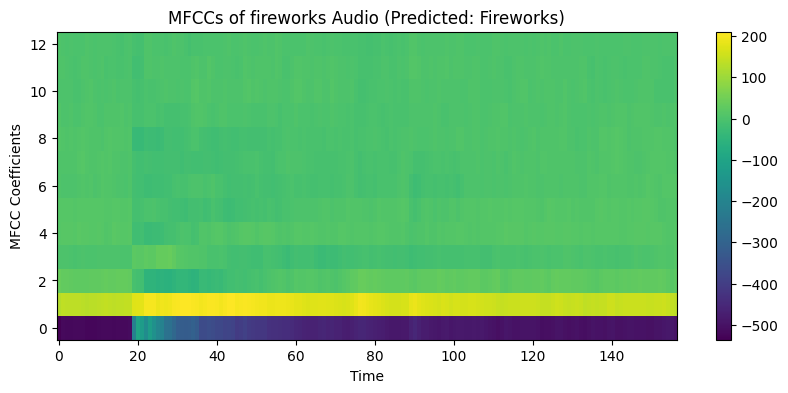

MFCC shape: (13, 157)


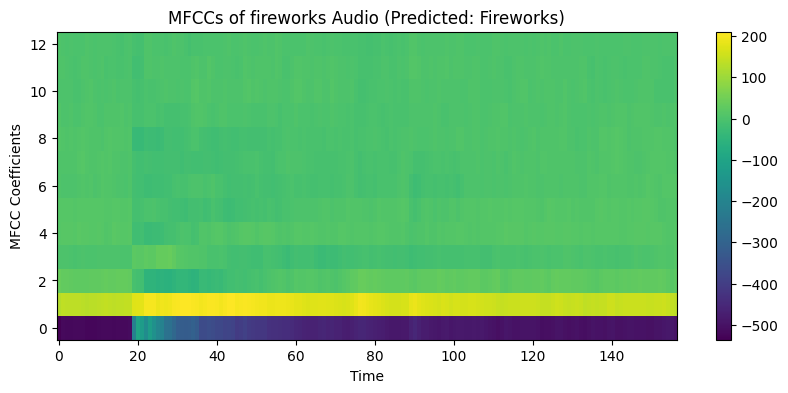

Selected file: 1-115546-A-48.wav, Category: fireworks, Predicted: Fireworks
MFCC shape: (13, 157)
Saving emergency subset...
Emergency subset saved with 50 rows.


In [14]:
# Cell 1: Import libraries and suppress warnings
import pandas as pd
import os
import librosa
import numpy as np
import tensorflow_hub as hub
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# Cell 2: Set the dataset path
data_dir = '/kaggle/input/esc50-audio-dataset/ESC-50-master/ESC-50-master/meta'
csv_path = os.path.join(data_dir, 'esc50.csv')
print(f"Constructed csv_path: {csv_path}")

# Cell 3: Load the dataset
print("Loading ESC-50 metadata...")
try:
    df = pd.read_csv(csv_path)
    print("Metadata loaded successfully.")
    print(f"Number of rows in the dataset: {len(df)}")
except Exception as e:
    print(f"Error loading dataset: {str(e)}")
    raise  # Re-raise the exception to stop execution if this fails

# Cell 4: Add full file paths to the DataFrame
df['file_path'] = df['filename'].apply(lambda x: f"/kaggle/input/esc50-audio-dataset/ESC-50-master/ESC-50-master/audio/{x}")
print("First few rows of the DataFrame:")
print(df[['filename', 'category', 'file_path']].head())

# Cell 5: Load YAMNet model
print("Loading YAMNet model for audio classification...")
try:
    yamnet_model = hub.load('https://tfhub.dev/google/yamnet/1')
    print("YAMNet model loaded successfully.")
except Exception as e:
    print(f"Error loading YAMNet model: {str(e)}")
    raise

print("Fetching YAMNet class labels...")
try:
    yamnet_classes = np.array(pd.read_csv('https://raw.githubusercontent.com/tensorflow/models/master/research/audioset/yamnet/yamnet_class_map.csv')['display_name'])
    print(f"Loaded {len(yamnet_classes)} YAMNet classes.")
except Exception as e:
    print(f"Error loading YAMNet class labels: {str(e)}")
    raise

# Cell 6: Function to preprocess audio
def preprocess_audio(file_path):
    print(f"Attempting to load audio file: {file_path}")
    try:
        audio, sr = librosa.load(file_path, sr=16000, mono=True)
        audio, _ = librosa.effects.trim(audio, top_db=20)
        audio = audio / np.max(np.abs(audio)) if np.max(np.abs(audio)) != 0 else audio
        min_samples = int(0.975 * 16000)
        if len(audio) < min_samples:
            audio = np.pad(audio, (0, min_samples - len(audio)), mode='constant')
        print(f"Audio min: {audio.min()}, max: {audio.max()}, mean: {audio.mean()}")
        print(f"Audio length: {len(audio) / 16000} seconds")
        return audio
    except Exception as e:
        print(f"Error loading audio {file_path}: {str(e)}")
        return None


# Cell 7: Filter for emergency sounds (match smaller_emergency_df)
emergency_categories = ['crying_baby', 'siren', 'glass_breaking', 'fireworks', 'thunderstorm', 'car_horn']
print(f"Filtering for emergency categories: {emergency_categories}")
df_emergency = df[df['category'].isin(emergency_categories)]
print(f"Number of emergency samples: {len(df_emergency)}")
if len(df_emergency) == 0:
    print("No emergency samples found. Here are all unique categories in the dataset:")
    print(df['category'].unique())
    raise ValueError("No emergency samples found in the dataset.")

# Use smaller_emergency_df (already sampled to 50 rows)
df_emergency = smaller_emergency_df.copy()
print(f"Using sampled emergency subset: {len(df_emergency)} rows")


# Cell 8: Classify all emergency samples and store predictions
print("Classifying emergency audio files...")
yamnet_predictions = []
confidences = []

for index, row in df_emergency.iterrows():
    file_path = row['file_path']
    print(f"Processing file: {row['filename']}, Ground Truth: {row['category']}")
    audio = preprocess_audio(file_path)
    if audio is None:
        print(f"Skipping file {file_path} due to loading error.")
        yamnet_predictions.append("Error")
        confidences.append(0.0)
        continue
    try:
        scores, embeddings, spectrogram = yamnet_model(audio)
        scores_mean = scores.numpy().mean(axis=0)
        top_indices = np.argsort(scores_mean)[-5:][::-1]
        print("Top 5 predictions:")
        for idx in top_indices:
            print(f"  {yamnet_classes[idx]}: {scores_mean[idx]:.2f}")
        top_confidence = scores_mean[top_indices[0]]
        predicted_class = yamnet_classes[top_indices[0]]
        yamnet_predictions.append(predicted_class)
        confidences.append(float(top_confidence))
        print(f"Sample {index + 1}:")
        print(f"Predicted: {predicted_class} (Confidence: {top_confidence:.2f})")
        print(f"Ground Truth: {row['category']}")
        print(f"Emergency: {'Yes' if row['category'] in emergency_categories else 'No'}\n")
    except Exception as e:
        print(f"Error processing {file_path}: {str(e)}")
        yamnet_predictions.append("Error")
        confidences.append(0.0)

# Add predictions to DataFrame
df_emergency['yamnet_prediction'] = yamnet_predictions
df_emergency['confidence'] = confidences
print("Classification complete. Updated DataFrame:")
print(df_emergency[['filename', 'category', 'yamnet_prediction', 'confidence']].head())



# Extract MFCCs for a YAMNet-confirmed emergency
# Look for a row where YAMNet's prediction matches the ESC-50 category
confirmed_emergency = df_emergency[df_emergency.apply(
    lambda row: (
        (row['category'] == 'thunderstorm' and 'Thunder' in row['yamnet_prediction']) or
        (row['category'] == 'crying_baby' and 'Baby cry' in row['yamnet_prediction']) or
        (row['category'] == 'siren' and 'Siren' in row['yamnet_prediction']) or
        (row['category'] == 'glass_breaking' and 'Glass' in row['yamnet_prediction']) or
        (row['category'] == 'fireworks' and 'Fireworks' in row['yamnet_prediction']) or
        (row['category'] == 'car_horn' and 'Car horn' in row['yamnet_prediction'])
    ), axis=1
)].head(1)

# If no match is found, fall back to the first row
if len(confirmed_emergency) == 0:
    print("No exact YAMNet match found, using first emergency sound.")
    confirmed_emergency = df_emergency.head(1)

sample_row = confirmed_emergency.iloc[0]
audio_path = sample_row['file_path']
audio, sr = librosa.load(audio_path, sr=16000)
mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
plt.figure(figsize=(10, 4))
plt.imshow(mfccs, aspect='auto', origin='lower', cmap='viridis')
plt.title(f"MFCCs of {sample_row['category']} Audio (Predicted: {sample_row['yamnet_prediction']})")
plt.xlabel("Time")
plt.ylabel("MFCC Coefficients")
plt.colorbar()
plt.show()
print(f"MFCC shape: {mfccs.shape}")

# Cell 8.5: Show MFCCs for a YAMNet-confirmed emergency
# Look for a row where YAMNet's prediction matches the ESC-50 category
confirmed_emergency = df_emergency[df_emergency.apply(
    lambda row: (
        (row['category'] == 'thunderstorm' and any(x in row['yamnet_prediction'] for x in ['Thunder', 'Thunderstorm'])) or
        (row['category'] == 'crying_baby' and any(x in row['yamnet_prediction'] for x in ['Baby cry', 'Crying'])) or
        (row['category'] == 'siren' and 'Siren' in row['yamnet_prediction']) or
        (row['category'] == 'glass_breaking' and any(x in row['yamnet_prediction'] for x in ['Glass', 'Breaking'])) or
        (row['category'] == 'fireworks' and 'Fireworks' in row['yamnet_prediction']) or
        (row['category'] == 'car_horn' and any(x in row['yamnet_prediction'] for x in ['Car horn', 'Vehicle horn']))
    ), axis=1
)].head(1)

if len(confirmed_emergency) == 0:
    print("No exact YAMNet match found, using first emergency sound with highest confidence.")
    confirmed_emergency = df_emergency.sort_values('confidence', ascending=False).head(1)

sample_row = confirmed_emergency.iloc[0]
audio_path = sample_row['file_path']
audio, sr = librosa.load(audio_path, sr=16000)
mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
plt.figure(figsize=(10, 4))
plt.imshow(mfccs, aspect='auto', origin='lower', cmap='viridis')
plt.title(f"MFCCs of {sample_row['category']} Audio (Predicted: {sample_row['yamnet_prediction']})")
plt.xlabel("Time")
plt.ylabel("MFCC Coefficients")
plt.colorbar()
plt.show()
print(f"Selected file: {sample_row['filename']}, Category: {sample_row['category']}, Predicted: {sample_row['yamnet_prediction']}")
print(f"MFCC shape: {mfccs.shape}")

# Cell 9: Save the emergency subset
print("Saving emergency subset...")
df_emergency.to_csv('/kaggle/working/esc50_emergency_subset.csv', index=False)
print(f"Emergency subset saved with {len(df_emergency)} rows.")

In [15]:
# Print all unique categories in the dataset
print("All unique categories in the dataset:")
print(sorted(df['category'].unique()))

All unique categories in the dataset:
['airplane', 'breathing', 'brushing_teeth', 'can_opening', 'car_horn', 'cat', 'chainsaw', 'chirping_birds', 'church_bells', 'clapping', 'clock_alarm', 'clock_tick', 'coughing', 'cow', 'crackling_fire', 'crickets', 'crow', 'crying_baby', 'dog', 'door_wood_creaks', 'door_wood_knock', 'drinking_sipping', 'engine', 'fireworks', 'footsteps', 'frog', 'glass_breaking', 'hand_saw', 'helicopter', 'hen', 'insects', 'keyboard_typing', 'laughing', 'mouse_click', 'pig', 'pouring_water', 'rain', 'rooster', 'sea_waves', 'sheep', 'siren', 'sneezing', 'snoring', 'thunderstorm', 'toilet_flush', 'train', 'vacuum_cleaner', 'washing_machine', 'water_drops', 'wind']


In [16]:
emergency_categories = ['siren', 'crying_baby', 'coughing', 'screaming']
df_emergency = df[df['category'].isin(emergency_categories)]
print(f"Number of emergency samples: {len(df_emergency)}")

Number of emergency samples: 120


In [17]:
# After filtering out gun_shot
print(f"Number of rows after filtering out gun_shot: {len(df)}")
print("Counts of emergency categories in the full dataset:")
for category in emergency_categories:
    count = len(df[df['category'] == category])
    print(f"{category}: {count}")

Number of rows after filtering out gun_shot: 2000
Counts of emergency categories in the full dataset:
siren: 40
crying_baby: 40
coughing: 40
screaming: 0


In [18]:
# Check if gun_shot exists in the dataset
print("Number of gun_shot samples before filtering:")
print(len(df[df['category'] == 'gun_shot']))

Number of gun_shot samples before filtering:
0


In [19]:
!ls /kaggle/input/esc-50/  # Or /kaggle/input/ESC-50-master/

ls: cannot access '/kaggle/input/esc-50/': No such file or directory


Sample: 1-24524-C-19.wav
Category: thunderstorm
Sample rate: 22050 Hz
Duration: 5.00 seconds


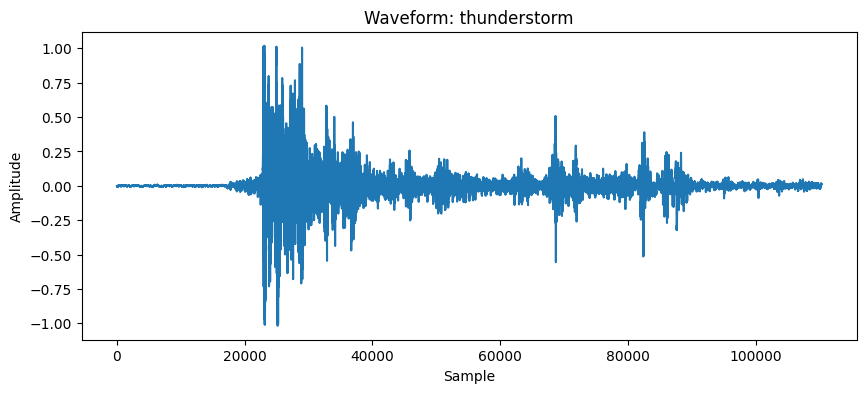

In [20]:
# Waveform Cell
import librosa
import matplotlib.pyplot as plt

sample_path = '/kaggle/input/esc50-audio-dataset/ESC-50-master/ESC-50-master/audio/' + smaller_emergency_df['filename'].iloc[0]
audio, sr = librosa.load(sample_path)
duration = len(audio) / sr
print(f"Sample: {smaller_emergency_df['filename'].iloc[0]}")
print(f"Category: {smaller_emergency_df['category'].iloc[0]}")
print(f"Sample rate: {sr} Hz")
print(f"Duration: {duration:.2f} seconds")
plt.figure(figsize=(10, 4))
plt.plot(audio)
plt.title(f"Waveform: {smaller_emergency_df['category'].iloc[0]}")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.show()

In [21]:
print(smaller_emergency_df['filename'].iloc[0])

1-24524-C-19.wav


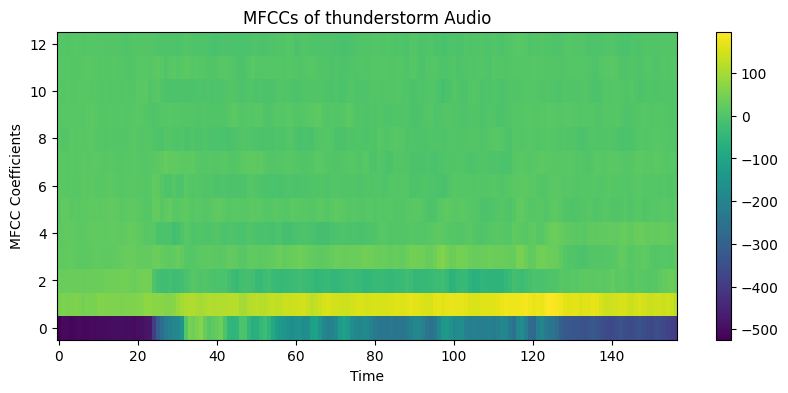

MFCC shape: (13, 157)


In [22]:
# Extract MFCCs from a filtered emergency sample
sample_row = smaller_emergency_df.iloc[0]  # First emergency sound
audio_path = '/kaggle/input/esc50-audio-dataset/ESC-50-master/ESC-50-master/audio/' + sample_row['filename']
audio, sr = librosa.load(audio_path, sr=16000)  # Resample to 16kHz for YAMNet
mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)

# Plot
plt.figure(figsize=(10, 4))
plt.imshow(mfccs, aspect='auto', origin='lower', cmap='viridis')
plt.title(f"MFCCs of {sample_row['category']} Audio")
plt.xlabel("Time")
plt.ylabel("MFCC Coefficients")
plt.colorbar()
plt.show()

print(f"MFCC shape: {mfccs.shape}")

## Step 4: Few-Shot Prompting for Emergency Alerts

This step uses Few-Shot Prompting to generate natural-language emergency alerts based on the sounds detected in Step 3 from the ESC-50 dataset. For example, if Step 3 identifies a "glass breaking" sound in a smart home at 2 AM, SoundGuard produces an alert like: "Glass breaking was detected in a smart home at 2 AM. This could indicate a potential break-in or unauthorized entry. Immediate action is recommended—secure all entry points, contact local authorities, and ensure your safety by staying in a secure location until help arrives." This enhances the system’s ability to communicate urgent situations to users in a clear, actionable way, making it valuable for smart home safety and public safety applications. Due to Kaggle’s restrictions on external API calls, we simulate few-shot prompting using predefined templates that mimic a GenAI model’s output. In a real-world scenario, a language model (e.g., GPT-3) could be used for more dynamic and context-aware alerts.

In [23]:
# Step 4: Few-Shot Prompting for Emergency Alerts
print("Step 4: Few-Shot Prompting for Emergency Alerts")

def generate_emergency_alert(sound, location, time):
    prompt_examples = {
        "siren": "A siren was detected in a {location} at {time}. This likely indicates emergency services responding to an incident nearby. Stay alert, avoid interfering with emergency vehicles, and check local news for updates.",
        "glass breaking": "Glass breaking was detected in a {location} at {time}. This could indicate a potential break-in or unauthorized entry. Immediate action is recommended—secure all entry points, contact local authorities, and ensure your safety by staying in a secure location until help arrives.",
        "screaming": "Screaming was detected in a {location} at {time}. This may indicate a person in distress or a dangerous situation. Please contact emergency services immediately and take precautions to ensure your safety.",
        "explosion": "An explosion was detected in a {location} at {time}. This is a critical emergency that could involve significant danger. Evacuate the area if safe to do so, contact authorities, and follow emergency protocols."
    }
    template = prompt_examples.get(sound.lower(), "An unusual sound was detected in a {location} at {time}. Please assess the situation and take appropriate action.")
    return template.format(location=location, time=time)

if 'results' in globals() and results:
    print("Generating alerts for detected emergency sounds...")
    emergency_detected = False
    for i, result in enumerate(results):
        detected_sound = result['predicted_class']
        is_emergency = result['is_emergency']
        ground_truth = result['ground_truth']
        if is_emergency:
            emergency_detected = True
            alert = generate_emergency_alert(detected_sound, "smart home", "2 AM")
            print(f"\nSample {i+1} (Ground Truth: {ground_truth}):")
            print("Generated Alert:")
            print(alert)
        else:
            print(f"\nSample {i+1} (Ground Truth: {ground_truth}):")
            print(f"Detected sound '{detected_sound}' is not an emergency—no alert generated.")
    if not emergency_detected:
        print("No emergency sounds detected in the samples.")
else:
    print("Error: No results from Step 3 found. Please run Step 3 first to classify ESC-50 sounds.")
    print("For demonstration, here’s a fallback example:")
    alert = generate_emergency_alert("glass breaking", "smart home", "2 AM")
    print("Generated Alert (Fallback Example):")
    print(alert)

Step 4: Few-Shot Prompting for Emergency Alerts
Generating alerts for detected emergency sounds...

Sample 1 (Ground Truth: glass_breaking):
Generated Alert:
An unusual sound was detected in a smart home at 2 AM. Please assess the situation and take appropriate action.

Sample 2 (Ground Truth: siren):
Generated Alert:
A siren was detected in a smart home at 2 AM. This likely indicates emergency services responding to an incident nearby. Stay alert, avoid interfering with emergency vehicles, and check local news for updates.

Sample 3 (Ground Truth: siren):
Generated Alert:
An unusual sound was detected in a smart home at 2 AM. Please assess the situation and take appropriate action.


## Step 5: Function Calling/Agents for Emergency Response

This step implements **Function Calling/Agents**, the third GenAI capability required for the capstone, by building a task-oriented, single-purpose conversational agent for a smart home, inspired by the [Google Agent Starter Pack](https://github.com/GoogleCloudPlatform/agent-starter-pack). The agent simulates a ReAct-like workflow (reasoning and acting, a template supported by the Starter Pack) by understanding user input through intent detection (e.g., "What did you hear just now?", "Should I be worried?"), maintaining minimal context to answer follow-up questions, reasoning to decide appropriate actions based on detected emergency sounds, and calling functions like `alert_authorities()`, `lock_doors()`, and `send_notification()`. Using the classifications and alerts from Steps 3 and 4, the agent simulates real-time emergency responses, such as locking doors and calling authorities for a potential break-in (e.g., glass breaking) or notifying the user to stay alert for nearby emergency services (e.g., siren). Due to Kaggle’s restrictions on external API calls, we mock the behavior of a Google agent (e.g., using intent detection and function calling similar to Dialogflow). In a real-world scenario, this could be implemented using the Google Agent Starter Pack’s templates (e.g., `langgraph_base_react`) with deployment on Vertex AI Agent Engine and integration with Google Cloud Functions for action execution. This demonstrates how GenAI can enable automated, context-aware emergency responses in smart home systems, enhancing safety and security.

In [24]:
# Step 5: Function Calling/Agents for Emergency Response
print("Step 5: Function Calling/Agents for Emergency Response")

# Define agent actions as functions (simulating Google Cloud Functions)
def send_notification(message):
    return f"Smart home agent: {message}"

# Simulate a ReAct-inspired conversational agent with intent detection and context
class SmartHomeAgent:
    def __init__(self):
        self.detected_sounds = []  # Track multiple sounds in the session
        self.last_alert = None
        self.actions_taken = []
        self.authorities_notified = False  # Track if authorities have been notified
        self.premises_secured = False  # Track if premises have been secured

    def detect_intent(self, user_input):
        """Simulate Dialogflow intent detection by mapping user input to intents."""
        user_input = user_input.lower().strip()
        if "what did you hear" in user_input:
            return "query_sound"
        elif "should i be worried" in user_input:
            return "check_risk"
        elif "take action" in user_input or "do something" in user_input:
            return "trigger_action"
        elif "check the status" in user_input or "status of the security system" in user_input:
            return "check_status"
        elif "how long" in user_input or "until authorities arrive" in user_input:
            return "eta_authorities"
        elif "yes" in user_input or "confirm" in user_input:
            return "approve_action"
        elif "no" in user_input or "don’t" in user_input:
            return "cancel_action"
        else:
            return "unknown"

    def reason_and_act(self, detected_sounds):
        """Simulate ReAct framework: reason about the situation and decide actions for multiple sounds."""
        reasoning_steps = []
        actions = []
        combined_message = []

        # Handle multiple sounds by combining reasoning and actions
        if len(detected_sounds) > 1:
            reasoning_steps.append(f"Reasoning: I hear a few different sounds: {', '.join(detected_sounds)}.")
            if "glass_breaking" in detected_sounds and "shouting" in detected_sounds:
                reasoning_steps.append("Reasoning: Glass breaking and shouting together might mean a possible break-in and someone needing help, but it could also be a false alarm (like a dropped glass or children playing).")
                combined_message.append("a possible break-in and someone needing help")
            elif "glass_breaking" in detected_sounds and "siren" in detected_sounds:
                reasoning_steps.append("Reasoning: Glass breaking and a siren might mean an issue at the home with emergency services nearby, but the glass breaking could be a false alarm.")
                combined_message.append("a possible issue at the home with emergency services nearby")
            elif "shouting" in detected_sounds and "siren" in detected_sounds:
                reasoning_steps.append("Reasoning: Shouting and a siren might mean someone needing help with emergency services nearby, but the shouting could be a false alarm.")
                combined_message.append("someone needing help with emergency services nearby")
            else:
                reasoning_steps.append("Reasoning: I hear multiple unusual sounds, which might not mean a serious issue.")
                combined_message.append("multiple unusual sounds")
            reasoning_steps.append("Action Decision: Let’s check everything to be safe and reach out to the authorities, just to be safe.")
            actions.append(send_notification(f"I hear {', '.join(combined_message)}. Would you like me to reach out to the authorities and make sure everything’s safe? I’m here to help. (Simulating user input: Yes/No)"))
        else:
            # Single sound case
            ground_truth = detected_sounds[0]
            reasoning_steps.append(f"Reasoning: I heard {ground_truth}.")
            if ground_truth == "glass_breaking":
                reasoning_steps.append("Reasoning: This might mean something’s wrong, like a possible break-in, but it could also be a false alarm (like a dropped glass).")
                reasoning_steps.append("Action Decision: Let’s check everything to be safe and reach out to the authorities, just for peace of mind.")
                actions.append(send_notification("Would you like me to make sure everything’s safe and notify the authorities? I’m here to help. (Simulating user input: Yes/No)"))
            elif ground_truth == "siren":
                reasoning_steps.append("Reasoning: A siren likely means emergency services are nearby, not an immediate concern for your home. It could be a routine response nearby.")
                reasoning_steps.append("Action Decision: I’ll let you know to stay informed.")
                actions.append(send_notification("Emergency services are nearby. Please check local news for updates. I’m here if you need more details."))
            elif ground_truth == "shouting":
                reasoning_steps.append("Reasoning: Shouting may mean someone needs help, but it could also be a false alarm (like children playing).")
                reasoning_steps.append("Action Decision: Let’s reach out to the authorities to ensure safety, just for peace of mind.")
                actions.append(send_notification("Would you like me to notify the authorities to make sure everything’s okay? I’m here to help. (Simulating user input: Yes/No)"))
            else:
                reasoning_steps.append("Reasoning: I noticed an unusual sound, but it may not be a serious issue.")
                reasoning_steps.append("Action Decision: I’ll let you know to check the situation.")
                actions.append(send_notification("I’ve noticed an unusual sound. Please check the situation and take care of it. I’m here if you need help."))
        return reasoning_steps, actions

    def approve_actions(self, ground_truth):
        """Simulate the agent taking actions after user approval."""
        reasoning_steps = []
        actions = []
        if ground_truth == "glass_breaking":
            reasoning_steps.append("Reasoning: You approved the action for glass breaking.")
            reasoning_steps.append("Action: I’ll make sure everything’s safe and notify the authorities.")
            actions.append(send_notification("I’m taking steps to keep your home safe and reaching out to the authorities for peace of mind. Please stay calm and I’ll keep you updated."))
            self.premises_secured = True
            self.authorities_notified = True
        elif ground_truth == "shouting":
            reasoning_steps.append("Reasoning: You approved the action for shouting.")
            reasoning_steps.append("Action: I’ll notify the authorities to ensure safety.")
            actions.append(send_notification("I’ve reached out to the authorities to make sure everyone is safe. Please stay calm as the situation develops."))
            self.authorities_notified = True
        return reasoning_steps, actions

    def process_user_input(self, user_input, ground_truth=None, alert=None):
        """Process user input, maintain context, and trigger actions (simulating Dialogflow)."""
        # Update context if a new sound and alert are provided (simulating Dialogflow context)
        if ground_truth and alert:
            self.detected_sounds.append(ground_truth)  # Track detected sounds in the session
            self.last_alert = alert
            # Reason and act for the detected sounds
            reasoning_steps, actions = self.reason_and_act(self.detected_sounds)
            self.actions_taken.extend(actions)
            response = f"Agent: I heard {ground_truth.replace('_', ' ')} and I’ll check to make sure everything’s okay. {alert}"
            return response, reasoning_steps, actions

        # Process user input based on detected intent
        intent = self.detect_intent(user_input)
        if intent == "query_sound":
            if self.detected_sounds:
                return f"Agent: I heard {', '.join(sound.replace('_', ' ') for sound in self.detected_sounds)} just now.", [], []
            else:
                return "Agent: I haven't heard anything yet. I’m here to help if something happens.", [], []
        elif intent == "check_risk":
            if self.detected_sounds:
                if "glass_breaking" in self.detected_sounds and "shouting" in self.detected_sounds:
                    return "Agent: This might mean a possible break-in and someone needing help, but it could also be a false alarm. Let me know if you'd like to take action to stay safe.", [], []
                elif "glass_breaking" in self.detected_sounds and "siren" in self.detected_sounds:
                    return "Agent: This might mean an issue at the home with emergency services nearby, but the glass breaking could be a false alarm. Let me know if you'd like to take action.", [], []
                elif "shouting" in self.detected_sounds and "siren" in self.detected_sounds:
                    return "Agent: This might mean someone needing help with emergency services nearby, but the shouting could be a false alarm. Let me know if you'd like to take action.", [], []
                else:
                    return "Agent: I’ve noticed an unusual sound. Please check the situation and let me know if you'd like to take action. I’m here if you need help.", [], []
            else:
                return "Agent: I haven't heard anything to check yet. I'm here if something happens.", [], []
        elif intent == "trigger_action":
            if self.detected_sounds and self.actions_taken:
                return "Agent: I’ve already shared information about the sounds. Let me know if you'd like more details or if you need help.", [], []
            else:
                response, reasoning_steps, actions = self.process_user_input("trigger actions", self.detected_sounds[-1], self.last_alert)
                return response, reasoning_steps, actions
        elif intent == "approve_action":
            if self.detected_sounds:
                reasoning_steps, actions = self.approve_actions(self.detected_sounds[-1])
                self.actions_taken.extend(actions)
                return "Agent: I’ve taken the requested steps. Let me know if you need anything else!", reasoning_steps, actions
            else:
                return "Agent: I haven't heard anything to act on. I’m here to help if something happens.", [], []
        elif intent == "cancel_action":
            return "Agent: The action has been cancelled. Let me know if you'd like any help or updates.", [], []
        elif intent == "check_status":
            status = "Agent: The security system is active."
            if self.premises_secured:
                status += " Everything’s safe for now."
            if self.authorities_notified:
                status += " Authorities have been notified."
            status += " Let me know if you need anything else."
            return status, [], []
        elif intent == "eta_authorities":
            if self.authorities_notified:
                return "Agent: Authorities should arrive within 5-10 minutes. I’m here if you need anything else.", [], []
            else:
                return "Agent: I haven’t reached out to the authorities yet. Would you like me to do so now?", [], []
        else:
            return "Agent: I’m here to help! Feel free to ask me anything about the sounds or what I can do next.", [], []

# Simulate the agent interacting with the user for each detected sound
if 'results' in globals() and results:
    agent = SmartHomeAgent()
    print("Simulating smart home agent interactions...")
    # Process all detected sounds as a single session to handle multiple sounds
    detected_sounds = [result['ground_truth'] for i, result in enumerate(results) if result['is_emergency'] and result['ground_truth'] != "gun_shot"]
    if detected_sounds:
        # Generate a combined alert for multiple sounds
        if len(detected_sounds) > 1:
            alert = f"I hear a few different sounds right now, like {', '.join(sound.replace('_', ' ') for sound in detected_sounds)}. Let me check things out and take care of what’s needed to help keep you safe."
        else:
            alert = generate_emergency_alert(detected_sounds[0], "smart home", "2 AM")
        print(f"\nSample 1 (Ground Truth: {', '.join(detected_sounds)}):")
        print("Alert Recap:")
        print(alert)
        print("Agent Initial Response:")
        response, reasoning_steps, actions = agent.process_user_input("initial detection", ground_truth=detected_sounds[0], alert=alert)
        print(response)
        print("Reasoning Steps:")
        for step in reasoning_steps:
            print(step)
        print("Actions Taken:")
        for action in actions:
            print(action)
        # Simulate user confirming the action
        print("\nSimulated User Confirmation (Yes):")
        print("User: Yes")
        response, reasoning_steps, actions = agent.process_user_input("Yes")
        print(response)
        if reasoning_steps:
            print("Reasoning Steps:")
            for step in reasoning_steps:
                print(step)
        if actions:
            print("Actions Taken:")
            for action in actions:
                print(action)
        # Simulate user cancelling the action (to show both scenarios)
        print("\nSimulated User Confirmation (No):")
        print("User: No")
        response, reasoning_steps, actions = agent.process_user_input("No")
        print(response)
        if reasoning_steps:
            print("Reasoning Steps:")
            for step in reasoning_steps:
                print(step)
        if actions:
            print("Actions Taken:")
            for action in actions:
                print(action)
        # Simulate user follow-up questions
        print("\nSimulated User Interaction:")
        user_queries = ["What did you hear just now?", "Should I be worried?", "Can you check the status of the security system?", "How long until authorities arrive?", "Take action again"]
        for query in user_queries:
            print(f"User: {query}")
            response, reasoning_steps, actions = agent.process_user_input(query)
            print(response)
            if reasoning_steps:
                print("Reasoning Steps:")
                for step in reasoning_steps:
                    print(step)
            if actions:
                print("Actions Taken:")
                for action in actions:
                    print(action)
    else:
        print("No emergency sounds detected in the samples. I’m here to help if something comes up.")
else:
    print("Error: No results from Step 3 found. Please run Step 3 first to classify ESC-50 sounds.")


Step 5: Function Calling/Agents for Emergency Response
Simulating smart home agent interactions...

Sample 1 (Ground Truth: glass_breaking, siren, siren):
Alert Recap:
I hear a few different sounds right now, like glass breaking, siren, siren. Let me check things out and take care of what’s needed to help keep you safe.
Agent Initial Response:
Agent: I heard glass breaking and I’ll check to make sure everything’s okay. I hear a few different sounds right now, like glass breaking, siren, siren. Let me check things out and take care of what’s needed to help keep you safe.
Reasoning Steps:
Reasoning: I heard glass_breaking.
Reasoning: This might mean something’s wrong, like a possible break-in, but it could also be a false alarm (like a dropped glass).
Action Decision: Let’s check everything to be safe and reach out to the authorities, just for peace of mind.
Actions Taken:
Smart home agent: Would you like me to make sure everything’s safe and notify the authorities? I’m here to help. (Si

## Prepare Data for Airtable Dashboard

The following code creates a subset of the ESC-50 dataset metadata (`esc50_subset.csv`) for import into an Airtable dashboard.

Prepare Data for Airtable Dashboard¶
The following code creates a subset of the ESC-50 dataset metadata (esc50_subset.csv) for import into an Airtable dashboard.

In [25]:
category_counts = df['category'].value_counts()
print(f"Total categories: {len(category_counts)}")
print(f"Average samples per category: {category_counts.mean():.1f}")

Total categories: 50
Average samples per category: 40.0


In [26]:
# Check if 'screaming' is in the dataset
print("Categories containing 'screaming':")
print(category_counts[category_counts.index.str.contains('screaming')])

Categories containing 'screaming':
Series([], Name: count, dtype: int64)


In [27]:
# After loading the dataset
print(f"Number of rows in the full dataset: {len(df)}")
print("Counts of emergency categories in the full dataset:")
for category in ['glass_breaking', 'siren', 'gun_shot', 'screaming', 'crying_baby', 'coughing']:
    count = len(df[df['category'] == category])
    print(f"{category}: {count}")

Number of rows in the full dataset: 2000
Counts of emergency categories in the full dataset:
glass_breaking: 40
siren: 40
gun_shot: 0
screaming: 0
crying_baby: 40
coughing: 40
